In [1]:
# imports
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import os
from matplotlib import pyplot as plt

In [2]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# extract data
!unzip /content/drive/MyDrive/Thesis/landmarks_files_alphabatically_WLASL_300.zip

Archive:  /content/drive/MyDrive/Thesis/landmarks_files_alphabatically_WLASL_300.zip
   creating: landmarks_files_(alphabatically)_WLASL_300/
   creating: landmarks_files_(alphabatically)_WLASL_300/a/
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/00295.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01610.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01611.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01612.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01613.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01614.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/01615.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a/66039.parquet  
   creating: landmarks_files_(alphabatically)_WLASL_300/a lot/
  inflating: landmarks_files_(alphabatically)_WLASL_300/a lot/02123.parquet  
  inflating: landmarks_files_(alphabatically)_WLASL_300/a lot/0212

In [4]:
FIXED_FRAMES = 25
# Choose required landmarks
IDX_MAP = {"lips"       : np.array([
                            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
                            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
                            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
                            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,]).tolist(),
           "left_hand"  : np.arange(468, 489).tolist(),
           "upper_body" : np.arange(489, 511).tolist(),
           "right_hand" : np.arange(522, 543).tolist()}

In [5]:
# Loading a single file for visualizing
df = pd.read_parquet('/content/landmarks_files_(alphabatically)_WLASL_300/advantage/01249.parquet')
df.sample(10)
# Load parquet file and convert it to required shape
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    # Convert NaN values to 0
    data = data.fillna(0)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)
    # Check if the function returns in required dimensions
single_pq = load_relevant_data_subset('/content/landmarks_files_(alphabatically)_WLASL_300/advantage/01249.parquet')
print(single_pq.shape)
print(len(IDX_MAP['lips']), len(IDX_MAP['left_hand']), len(IDX_MAP['upper_body']), len(IDX_MAP['right_hand']))

(54, 543, 3)
40 21 22 21


In [6]:
# normalising the data
class FeaturePreprocess(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x_in):
        n_frames = x_in.shape[0]

        # Normalization to a common mean
        x_in = x_in - x_in[~torch.isnan(x_in)].mean(0,keepdim=True)
        x_in = x_in / x_in[~torch.isnan(x_in)].std(0, keepdim=True)

        # Landmarks reduction
        lips     = x_in[:, IDX_MAP['lips']]
        lhand    = x_in[:, IDX_MAP['left_hand']]
        pose     = x_in[:, IDX_MAP['upper_body']]
        rhand    = x_in[:, IDX_MAP['right_hand']]
        x_in = torch.cat([lips,
                          lhand,
                          pose,
                          rhand], 1) # (n_frames, n_landmarks, 3)

        # Replace nan with 0
        x_in[torch.isnan(x_in)] = 0

        # interpolation
        x_in = x_in.permute(2,1,0)
        if n_frames < FIXED_FRAMES:
            x_in = F.interpolate(x_in, size=(FIXED_FRAMES), mode= 'linear')
        else:
            x_in = F.interpolate(x_in, size=(FIXED_FRAMES), mode= 'nearest-exact')

        return x_in.permute(2,1,0)

In [7]:
# FeaturePreprocess for one file
x_in = torch.tensor(load_relevant_data_subset('/content/landmarks_files_(alphabatically)_WLASL_300/advantage/01249.parquet'))
feature_preprocess = FeaturePreprocess()
print(feature_preprocess(x_in).shape, x_in[0])

torch.Size([25, 104, 3]) tensor([[ 0.5896,  0.3538, -0.0242],
        [ 0.5872,  0.3304, -0.0364],
        [ 0.5883,  0.3392, -0.0216],
        ...,
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])


In [8]:
signs = []
paths = []

root_folder = r"/content/landmarks_files_(alphabatically)_WLASL_300"

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        phrase = class_name
        path = f"/content/landmarks_files_(alphabatically)_WLASL_300/{class_name}/{file_name}"
        signs.append(phrase)
        paths.append(path)
data = {
    'sign': signs,
    'path': paths,
}

train_df = pd.DataFrame(data)

csv_filename = 'train.csv'
train_df.to_csv(csv_filename, index=False)

In [9]:
train_df.head()

,sign,path
0,asia,/content/landmarks_files_(alphabatically)_WLAS...
1,asia,/content/landmarks_files_(alphabatically)_WLAS...
2,asia,/content/landmarks_files_(alphabatically)_WLAS...
3,asia,/content/landmarks_files_(alphabatically)_WLAS...
4,asia,/content/landmarks_files_(alphabatically)_WLAS...


In [10]:
# Converting Signs to Orginal Encodings
train_df['sign_encode'] = train_df['sign'].astype('category').cat.codes

# Dictionary to translate sign to ordinal encoded sign
SIGN_TO_ENCODE = train_df[['sign', 'sign_encode']].set_index('sign').squeeze().to_dict()
ENCODE_TO_SIGN = train_df[['sign_encode', 'sign']].set_index('sign_encode').squeeze().to_dict()

In [11]:
train_df.head()

,sign,path,sign_encode
0,asia,/content/landmarks_files_(alphabatically)_WLAS...,101
1,asia,/content/landmarks_files_(alphabatically)_WLAS...,101
2,asia,/content/landmarks_files_(alphabatically)_WLAS...,101
3,asia,/content/landmarks_files_(alphabatically)_WLAS...,101
4,asia,/content/landmarks_files_(alphabatically)_WLAS...,101


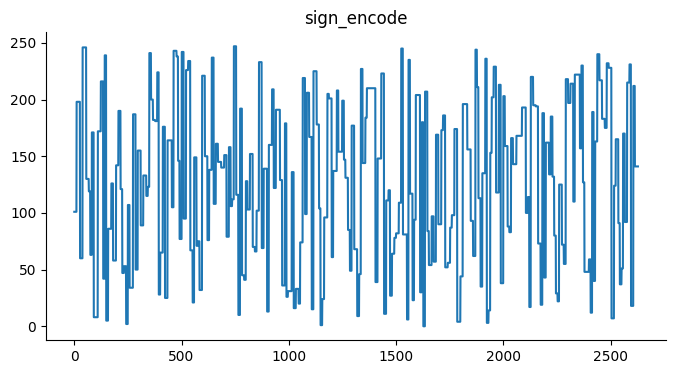

In [12]:
# sign_encode

train_df['sign_encode'].plot(kind='line', figsize=(8, 4), title='sign_encode')
plt.gca().spines[['top', 'right']].set_visible(False)

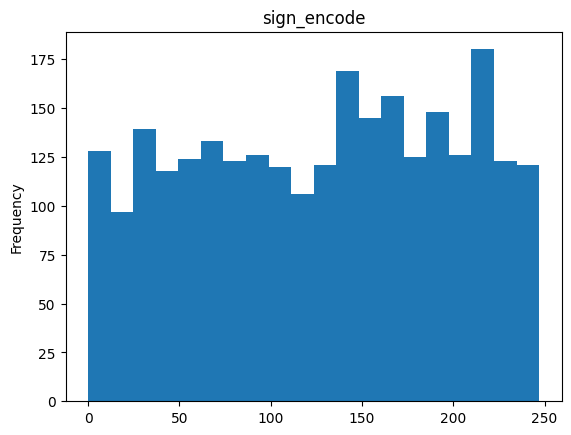

In [16]:
# sign_encode

train_df['sign_encode'].plot(kind='hist', bins=20, title='sign_encode')
plt.gca().spines[['top', 'right',]].set_visible(True)

In [14]:
print(SIGN_TO_ENCODE)

{'asia': 101, 'blanket': 198, 'america': 60, 'brother': 246, 'awful': 130, 'austria': 119, 'anatomy': 63, 'behavior': 171, 'accident': 8, 'behind': 172, 'boss': 216, 'aid': 42, 'bribe': 239, 'above': 5, 'approve': 86, 'awake': 126, 'always': 58, 'bald': 142, 'biology': 190, 'authority': 121, 'algebra': 47, 'almost': 53, 'abdomen': 2, 'attend': 107, 'again': 34, 'big': 187, 'allergy': 50, 'bath': 155, 'area': 89, 'baby': 133, 'audiology': 115, 'available': 123, 'brief': 241, 'bless': 200, 'bet': 182, 'best': 181, 'boxing': 224, 'adverb': 28, 'angel': 65, 'below': 176, 'adult': 25, 'bed': 164, 'assistant': 105, 'bring': 243, 'breeze': 238, 'bank': 146, 'apartment': 77, 'bright': 242, 'arrest': 95, 'boyfriend': 226, 'break': 234, 'angry': 67, 'adjust': 21, 'barely': 149, 'annoy': 71, 'anyway': 75, 'after': 32, 'bowl': 221, 'bark': 150, 'apart': 76, 'bacon': 138, 'breathe': 237, 'attention': 108, 'beautiful': 161, 'banana': 145, 'bake': 140, 'baseball': 151, 'appear': 79, 'battle': 158, 'a

In [15]:
len(SIGN_TO_ENCODE)

248